In [1]:
from myAE import Manager
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
manager = Manager()
manager.prepare_data()

def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)

In [3]:
hist = manager.train_on_cpu(calc_loss, epochs=30)

Now, it is working on cpu.


100%|██████████| 30/30 [05:42<00:00, 11.42s/it]


In [4]:
# take 5,000 points on the 2D latent space
base_points = torch.randn([5000, 2])

# decode the base points
with torch.no_grad():
    generated_imgs = manager.model.get_submodule('decoder')(base_points)

print(generated_imgs.shape)

torch.Size([5000, 1, 28, 28])


In [9]:
indices = []
# find nearest sample for each generated image
for img in generated_imgs:
    # make 60000 copy of img
    pred = torch.stack([img] * 60000)

    x = manager.training_data
    loss = F.binary_cross_entropy(pred, x, reduction='none')
    loss = loss.sum(dim=[1, 2, 3])

    # find index of least loss sample
    min_idx = loss.argmin().item()
    indices.append(min_idx)

print(indices)

[32132, 36750, 13287, 42124, 35729, 41069, 23515, 17605, 9620, 4027, 23515, 26047, 44788, 2664, 14741, 11361, 505, 43076, 12259, 59387, 57743, 55350, 31170, 20873, 18784, 4449, 28670, 8956, 53418, 13168, 49270, 32875, 9041, 50653, 13217, 3019, 42133, 13264, 4902, 19578, 52231, 37804, 48682, 51837, 34340, 35158, 21559, 1336, 7319, 23703, 4525, 53110, 20431, 35542, 42507, 44385, 36932, 47896, 11494, 50056, 52762, 46106, 25526, 10185, 22000, 16582, 7311, 17664, 10185, 1658, 53398, 30323, 37004, 38508, 19925, 4212, 43006, 51837, 27088, 1341, 28877, 57743, 13563, 33938, 4449, 59138, 49270, 49924, 34229, 35515, 8983, 17251, 31304, 46592, 23153, 50653, 16869, 39612, 13563, 40964, 10947, 40820, 27380, 24149, 17807, 43304, 2461, 40330, 14309, 51608, 10185, 47258, 11361, 17696, 12172, 26324, 56520, 52629, 52497, 54931, 43678, 25738, 3503, 11473, 4443, 24330, 26326, 1658, 17664, 10418, 56781, 27380, 45074, 27321, 34547, 8895, 36932, 10039, 58944, 3331, 50602, 32755, 54800, 56056, 38094, 3276, 530

In [10]:
print(len(indices))

5000


In [11]:
def show_100_images(imgs):
    tmp = torch.zeros(28 * 10, 28 * 10)
    
    for row in range(10):
        for col, img in enumerate(imgs[row * 10:(row + 1) * 10]):
            tmp[row * 28:(row + 1) * 28, col * 28: (col + 1) * 28] = img.view(28, 28)

    plt.figure(figsize=(20, 20))
    plt.imshow(tmp, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

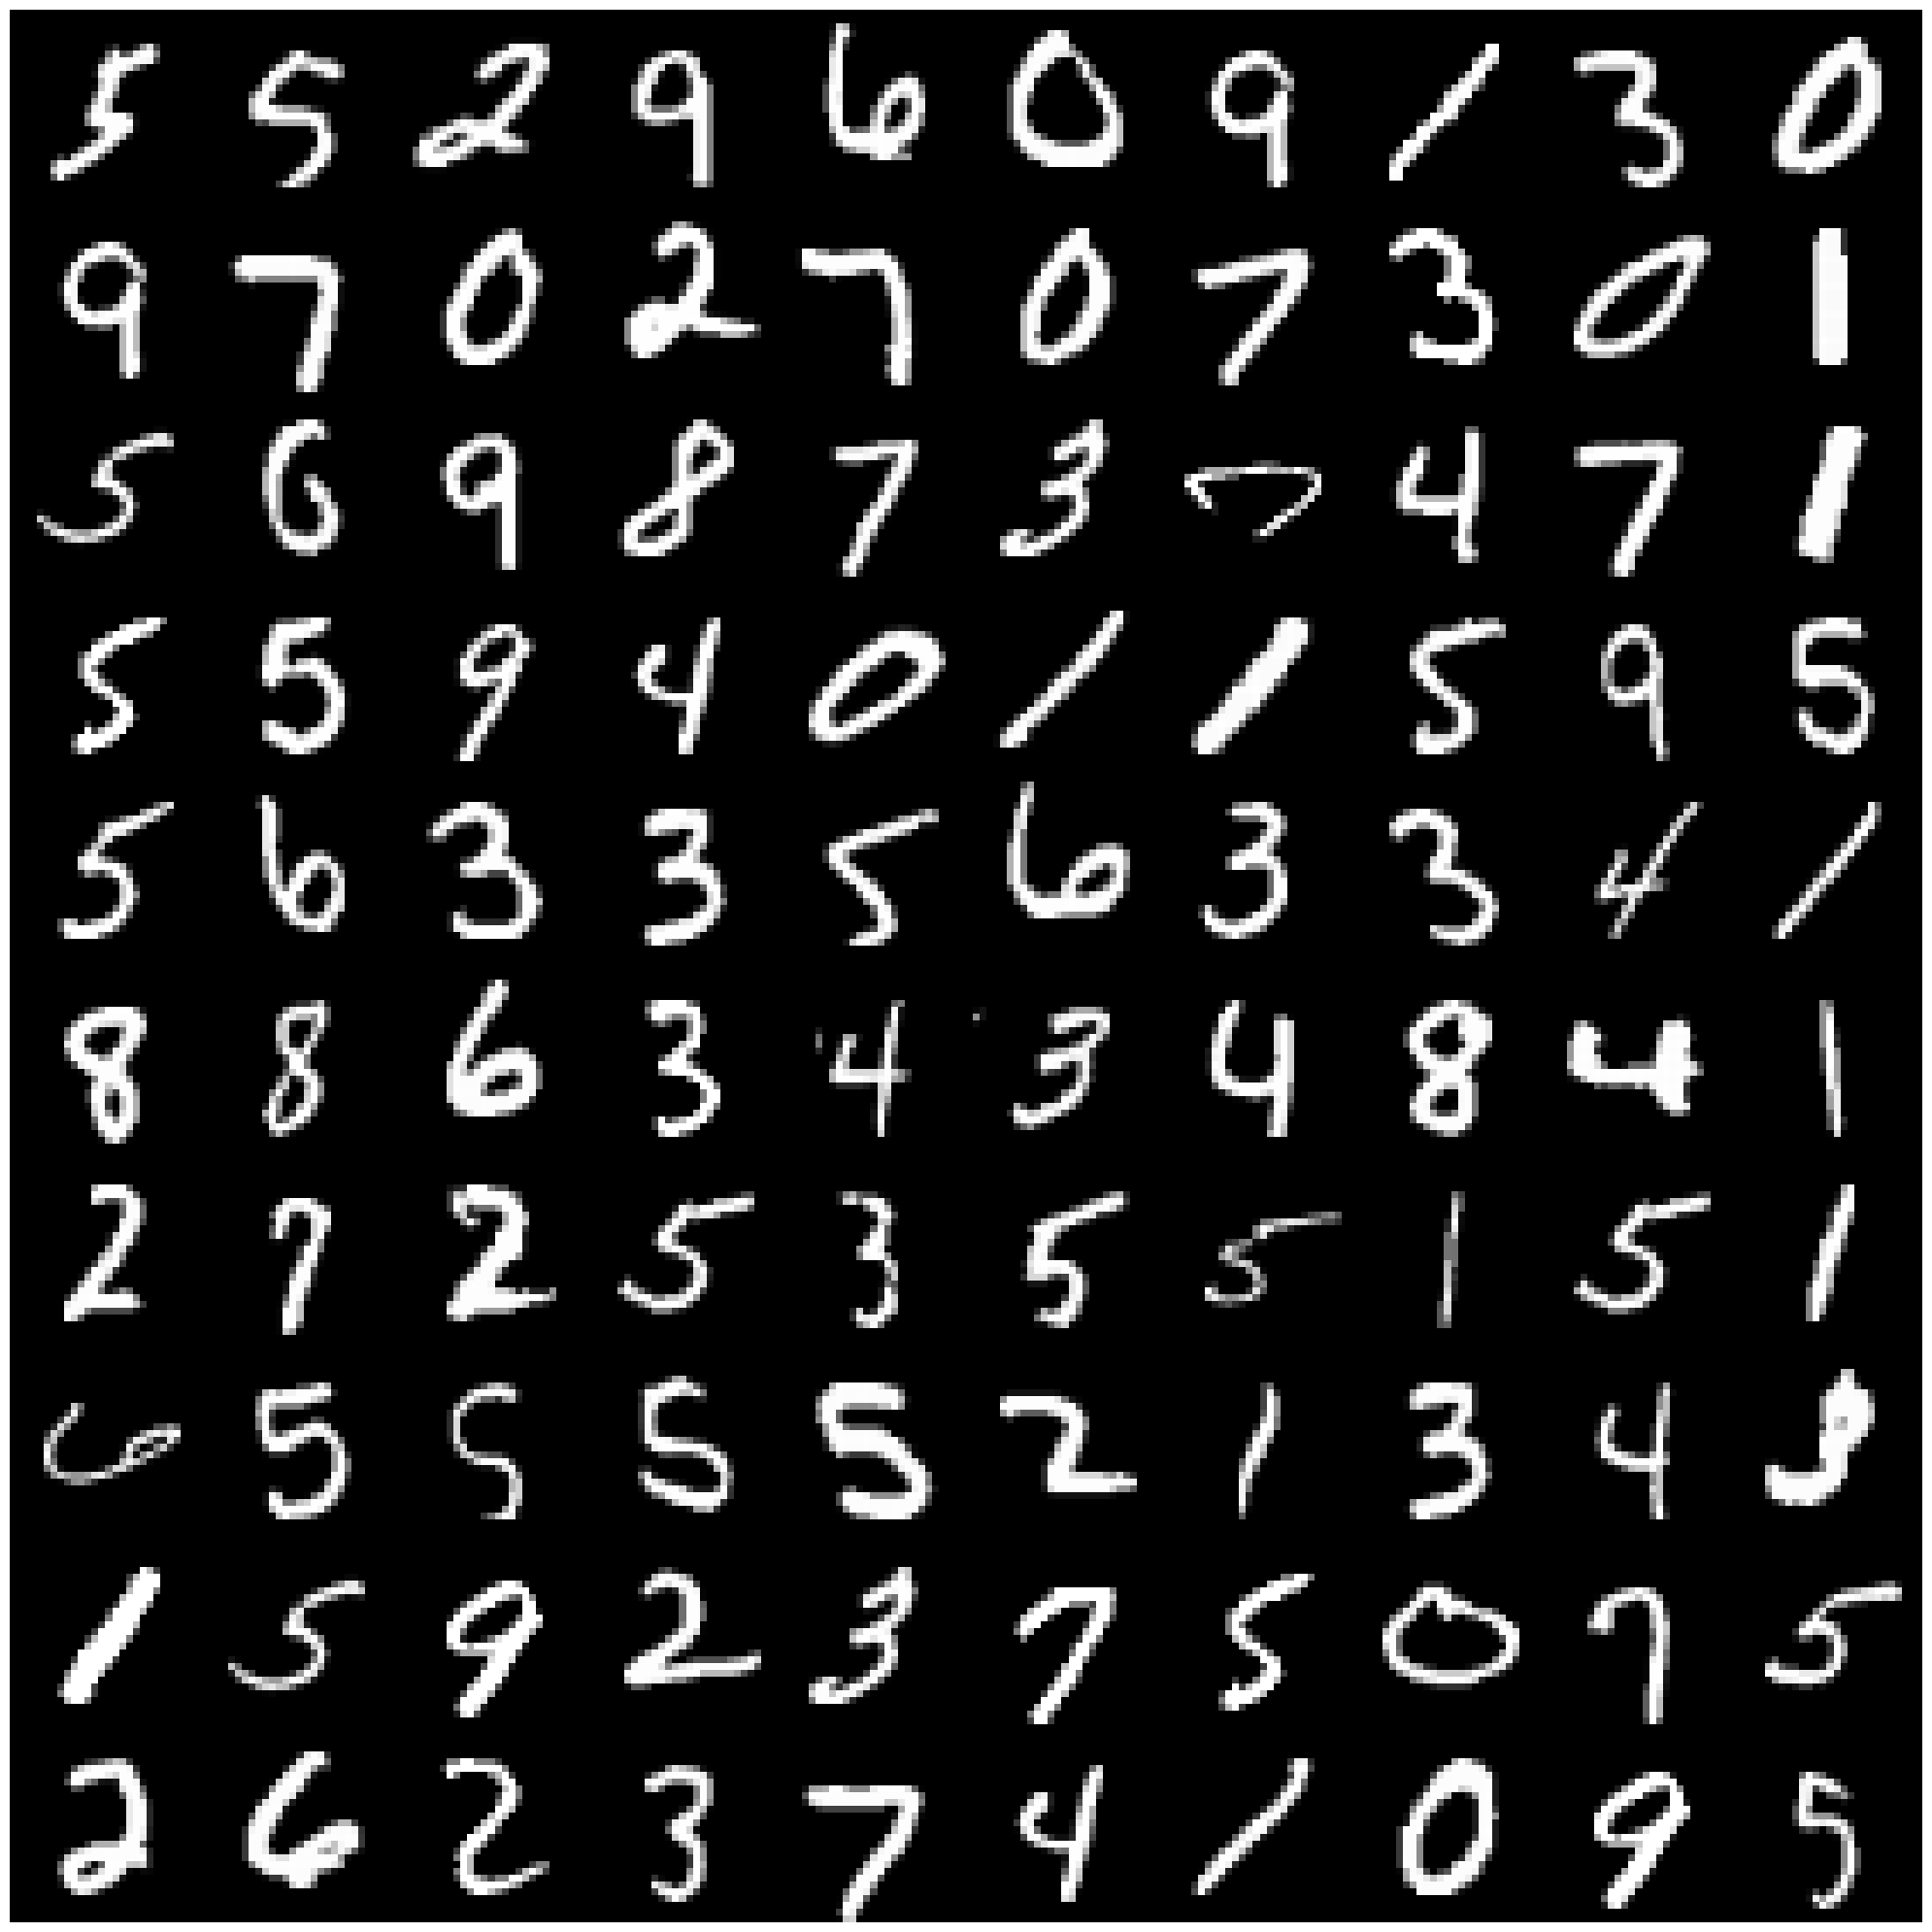

In [13]:
idx_tensor = torch.tensor(indices, dtype=torch.long)
show_100_images(manager.training_data[idx_tensor[:100]])

In [14]:
# set a new data loader
manager_2 = Manager()
manager_2.prepare_data()

from torch.utils.data import Dataset, DataLoader

class TmpDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

manager_2.training_data = manager.training_data[idx_tensor]
manager_2.training_targets = manager.training_targets[idx_tensor]

manager_2.training_data_length = len(x)

manager_2.train_dataloader = DataLoader(
    TmpDataset(manager_2.training_data, manager_2.training_targets), batch_size=128, shuffle=True
)

manager_2.set_default_model(4, 2)

In [15]:
hist_2 = manager_2.train_on_cpu(calc_loss, epochs=30)

Now, it is working on cpu.


100%|██████████| 30/30 [00:16<00:00,  1.79it/s]


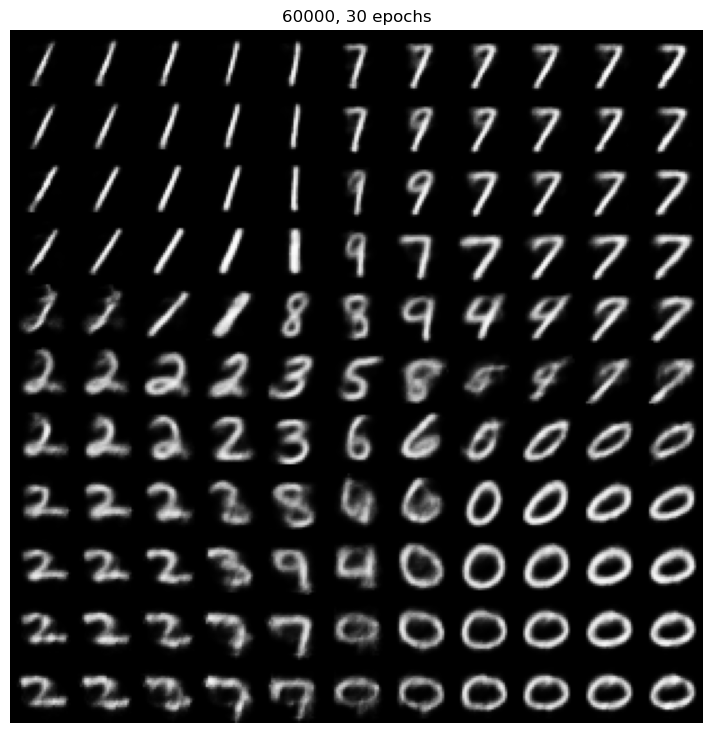

In [18]:
manager.plot_generated_images('60000, 30 epochs')

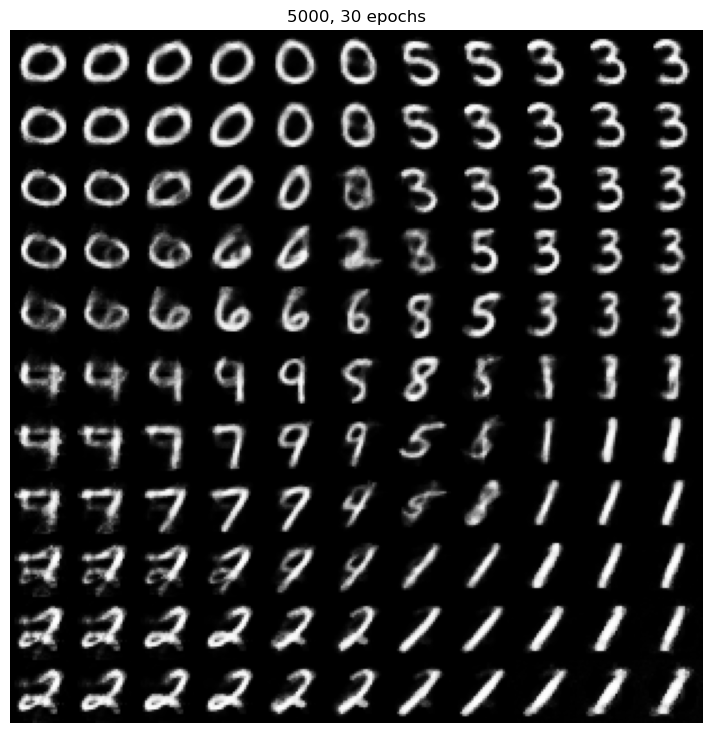

In [19]:
manager_2.plot_generated_images('5000, 30 epochs')

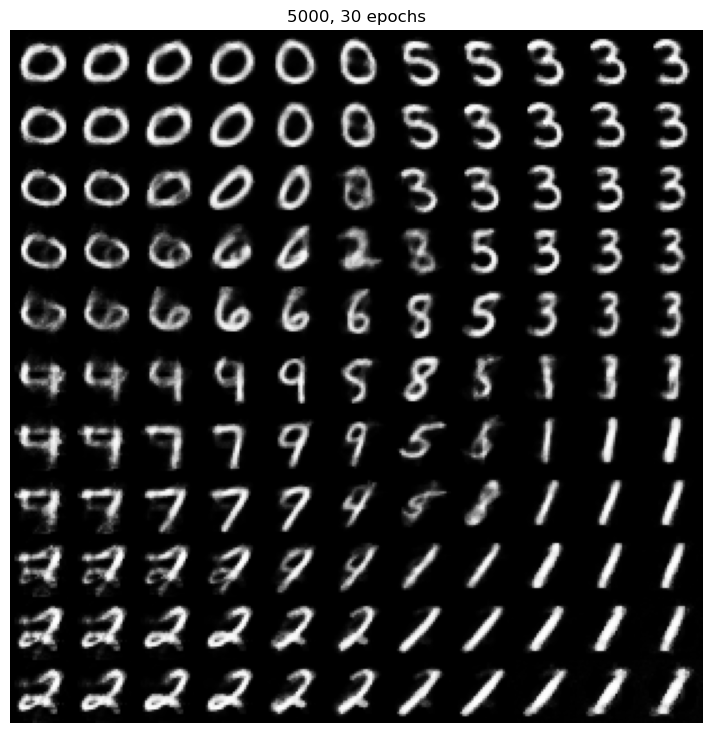

In [ ]:
manager_2.plot_generated_images('5000, 30 epochs')

In [20]:
hist_2_2 = manager_2.train_on_cpu(calc_loss, epochs=70)

Now, it is working on cpu.


100%|██████████| 70/70 [00:39<00:00,  1.78it/s]


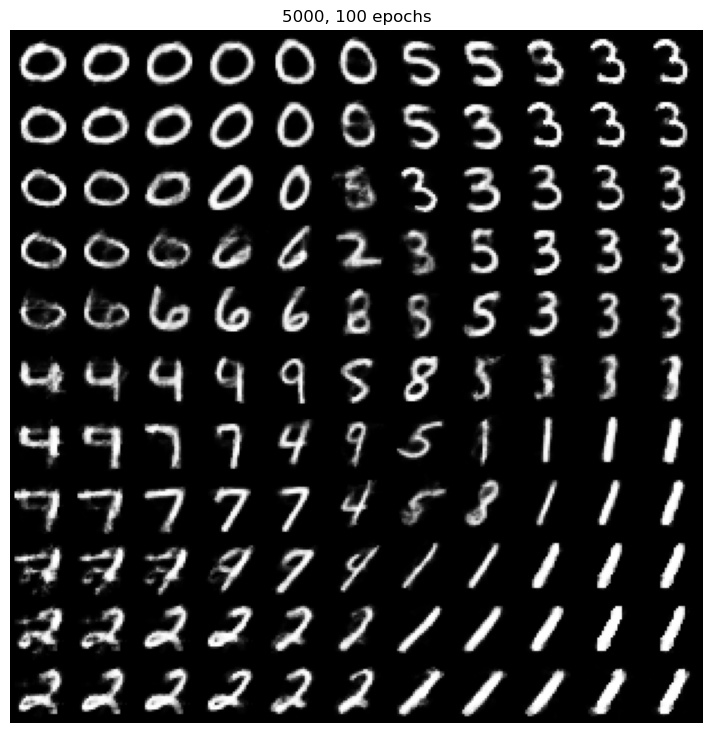

In [21]:
manager_2.plot_generated_images('5000, 100 epochs')